# capstone project - Battle of the neighbourhoods

## contents
* Introduction
* Datasets 
* EDA and Modeling
* Results and Conclusion

### Introduction
This project aims to determine the safest and cost effective neighboourhood in the city of Newyork using multiple datasets. We will determine the best neighbourhood with the data available and then identify the most suitable neighbourhoods in the city with the help of the foursquare API which provides us with the venues that are provided in the explore end points.Once suitable neightbourhoods of a borough are determined we will then perform a suitable statistical modeling on the data at hand to gain certain useful insights that will help make a decision in purchasing a home in the city of Newyork.

### Datasets
* [Borough](#Borough) data taken from wikipedia - [link](https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City)
* [Crime](#Crime) dataset taken from nydata - [link](https://data.cityofnewyork.us/Public-Safety/NYC-crime/qb7u-rbmr)
* [NYC housing](#NYC) sales data taken from kaggle -  [link](https://www.kaggle.com/new-york-city/nyc-property-sales)
* [Foursquare API](#FS) - Venues for locations

### EDA and Modeling
Peliminary data clearning is perfomed on the data and explantions are given as comments in the code to explain each and every step.\
Clustering analysis using k-means is performed on the neighbourhoods selected to group them based on the venues available from the Foursquare Explore API.\
Analysis and approach to selection of neighbourhoods are mentioned in each codeblock as to the reason why certain decisions are made in regards to the selection of neighbourhoods.





<a id='data'></a>
Data
[data](#data)

#### Importing all necessary Libraries for the project

In [168]:
import requests;import pandas as pd;import numpy as np
from bs4 import BeautifulSoup as bs4
from IPython.display import display, Markdown
import os;import time
import matplotlib.pyplot as plt
import requests,json
from json import loads
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import folium
#sns.set(style='white', context='notebook', palette='deep') 
pd.set_option('display.max_rows', 500)
plt.style.use('tableau-colorblind10')

<a id='Borough'></a>
#### Getting list of neighbourhoods of newyork from wikipedia

In [203]:
# Beautiful soup and requests are used obtain the html code from wikipedia and it is parsed as a dataframe with pandas
s = requests.Session()
url='https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City'
res=s.get(url)
soup=bs4(res.text,'xml')
table = soup.find_all('table', {'class':'wikitable sortable'})
ny = pd.read_html(str(table[0]), index_col=None, header=0)[0]
ny.tail()
new=ny["Community Board(CB)"].str.split("CB", n = 5, expand = True) 
ny['Borough']=new[0]
ny=ny[['Borough','Community Board(CB)', 'Areakm2', 'Pop.Census2010', 'Pop./km2',
       'Neighborhoods']]
ny=ny[['Borough','Community Board(CB)','Neighborhoods']]

ny=ny.join(ny.pop('Neighborhoods').str.split(',',expand=True))
ny=ny.set_index(['Borough','Community Board(CB)']).stack().reset_index(level=[0,1],name='Neighbourhood')
ny.reset_index(inplace = True, drop = True)
ny.sort_values(by='Neighbourhood').reset_index(drop=True).head(10)

,Borough,Community Board(CB),Neighbourhood
0,Staten Island,Staten Island CB 3,Arden Heights
1,Queens,Queens CB 1,Astoria Heights
2,Staten Island,Staten Island CB 3,Bay Terrace
3,Queens,Queens CB 11,Bayside
4,Queens,Queens CB 14,Bayswater
5,Queens,Queens CB 7,Beechhurst
6,Queens,Queens CB 14,Belle Harbor
7,Bronx,Bronx CB 6,Belmont
8,Brooklyn,Brooklyn CB 11,Bensonhurst
9,Staten Island,Staten Island CB 2,Bloomfield


Checking for duplicates

In [101]:
ny[ny.duplicated(['Neighbourhood'], keep=False)]
ny['Borough'].value_counts()

Queens            86
Brooklyn          80
Bronx             60
Staten Island     56
Manhattan         48
Name: Borough, dtype: int64

Removing duplicates

In [102]:
ny.drop_duplicates(subset ="Neighbourhood",keep = False, inplace = True)


Creating the function to get the location details using geopy

In [103]:
#creating the function and appending to a list then transforming that list into a dataframe with all the details returned by the function
temp=[]
geolocator = Nominatim(user_agent='my_email@myserver.com')
def geolocation(df):
    loc = pd.DataFrame()
    for i, j in df.iterrows(): 
        if i ==45:
            break
        try:         
            var=f"{j.Neighbourhood} {j.Borough}"
            #var=str(j.Neighbourhood)+' '+str(j.Borough)
            location = geolocator.geocode(var)
            name=var
            response=location.raw
            response["search_name"]=name
            response["Borough"]=j.Borough
            response["Neighbourhood"]=j.Neighbourhood            
            loc = loc.append(response, ignore_index=True)
        except:
            response={}
            var=f"{j.Neighbourhood} {j.Borough}"
            name=var
            response["search_name"]=name
            response["Borough"]=j.Borough
            response["Neighbourhood"]=j.Neighbourhood
            loc = loc.append(response, ignore_index=True)
    loc=loc[['search_name','lat','lon','importance','type','Neighbourhood','Borough','boundingbox','class']]
    return loc

In [104]:
df_nh=geolocation(ny)
df_nh

,search_name,lat,lon,importance,type,Neighbourhood,Borough,boundingbox,class
0,Melrose Bronx,40.8256703,-73.9152416,0.536855,station,Melrose,Bronx,"[40.8206703, 40.8306703, -73.9202416, -73.9102...",railway
1,Mott Haven Bronx,40.8089897,-73.9229147,0.623710,neighbourhood,Mott Haven,Bronx,"[40.8089397, 40.8090397, -73.9229647, -73.9228...",place
2,Port Morris Bronx,40.8015147,-73.9095811,0.606728,neighbourhood,Port Morris,Bronx,"[40.8014647, 40.8015647, -73.9096311, -73.9095...",place
3,Hunts Point Bronx,40.8126008,-73.8840247,0.673005,neighbourhood,Hunts Point,Bronx,"[40.8125508, 40.8126508, -73.8840747, -73.8839...",place
4,Longwood Bronx,40.8162916,-73.8962205,0.532702,station,Longwood,Bronx,"[40.8112916, 40.8212916, -73.9012205, -73.8912...",railway
5,Claremont Bronx,40.8341667,-73.9102778,0.350000,park,Claremont,Bronx,"[40.8341167, 40.8342167, -73.9103278, -73.9102...",leisure
6,Concourse Village Bronx,40.823868149999996,-73.92118091218828,0.500000,residential,Concourse Village,Bronx,"[40.8227742, 40.8249622, -73.9229217, -73.9194...",landuse
7,Crotona Park Bronx,40.838901899999996,-73.89386451155042,0.644356,park,Crotona Park,Bronx,"[40.8344186, 40.8434525, -73.9011324, -73.886757]",leisure
8,Morrisania Bronx,40.8292672,-73.9065253,0.540718,neighbourhood,Morrisania,Bronx,"[40.8292172, 40.8293172, -73.9065753, -73.9064...",place
9,Concourse Bronx,40.8185618,-73.927303,0.589675,station,Concourse,Bronx,"[40.8135618, 40.8235618, -73.932303, -73.922303]",railway


In [105]:
df_nh=df_nh.dropna()

<a id='Crime'></a>
## NewYork city Crimes 


In [213]:
crime0= pd.read_csv("data/crime ny0.csv",low_memory=False)
crime1=pd.read_csv("data/crime ny1.csv",low_memory=False)
crime=pd.concat([crime0, crime1], ignore_index=True)

#### Data Cleaning
* The crime data is over the time period of 11 months from nov-18' to sept-19' 
* The unwanted columns are removed from the dataframe as they add no value to the ojective at hand as they mainly comprise of codes of reference
* The columns are renamed to make them more readable to the viewer and descriptions are given below
~~~~
CMPLNT_NUM        - removed
CMPLNT_FR_DT      - complaintdate
CMPLNT_FR_TM      - complainttime
CMPLNT_TO_DT      -  complaintlastdate
CMPLNT_TO_TM      - complaintlasttime
ADDR_PCT_CD       - removed
RPT_DT            -  reporteddate
KY_CD             - removed
OFNS_DESC         - offencedescription
PD_CD             - removed
PD_DESC           - removed
CRM_ATPT_CPTD_CD  - status
LAW_CAT_CD        - crimecategory
BORO_NM           - borough
LOC_OF_OCCUR_DESC - crimelocation
PREM_TYP_DESC     - premisestype
JURIS_DESC        - removed
JURISDICTION_CODE - removed
PARKS_NM          - removed
HADEVELOPT        - removed
HOUSING_PSA       - removed
X_COORD_CD        - removed
Y_COORD_CD        - removed
SUSP_AGE_GROUP    - suspectage
SUSP_RACE         - suspectrace
SUSP_SEX          - suspectsex
TRANSIT_DISTRICT  - removed
Latitude          - removed
Longitude         - removed
Lat_Lon           - location
PATROL_BORO       - removed
STATION_NAME      - removed
VIC_AGE_GROUP     - victimeage
VIC_RACE          - victimerace
VIC_SEX           - victimesex
~~~~



In [214]:
crime.columns
remove=["Unnamed: 0","CMPLNT_NUM","ADDR_PCT_CD","KY_CD","PD_CD","PD_DESC","JURIS_DESC","JURISDICTION_CODE","PARKS_NM","HADEVELOPT","HOUSING_PSA","X_COORD_CD","Y_COORD_CD","TRANSIT_DISTRICT","Latitude","Longitude","PATROL_BORO","STATION_NAME"]
crime=crime.drop(remove, axis = 1) 


In [215]:
names={"CMPLNT_FR_DT":"complaintdate","CMPLNT_FR_TM":"complainttime","CMPLNT_TO_DT":"complaintlastdate","CMPLNT_TO_TM":"complaintlasttime","RPT_DT":"reporteddate","OFNS_DESC":"offencedescription","CRM_ATPT_CPTD_CD":"status","LAW_CAT_CD":"crimecategory","BORO_NM":"borough","LOC_OF_OCCUR_DESC":"crimelocation","PREM_TYP_DESC":"premisestype","SUSP_AGE_GROUP":"suspectage","SUSP_RACE":"suspectrace","SUSP_SEX":"suspectsex","Lat_Lon":"location","VIC_AGE_GROUP":"victimeage","VIC_RACE":"victimerace","VIC_SEX":"victimesex"}
crime=crime.rename(columns=names)


removing all irregular datapoints and outliers from the dataset

In [216]:
crime=crime.loc[crime['victimeage'].isin(['UNKNOWN','45-64','25-44','18-24','65+','<18'])]
crime=crime.loc[crime['suspectage'].isin(['UNKNOWN','45-64','25-44','18-24','65+','<18'])]
crime.columns

Index(['complaintdate', 'complainttime', 'complaintlastdate',
       'complaintlasttime', 'reporteddate', 'offencedescription', 'status',
       'crimecategory', 'borough', 'crimelocation', 'premisestype',
       'suspectage', 'suspectrace', 'suspectsex', 'location', 'victimeage',
       'victimerace', 'victimesex'],
      dtype='object')

In [220]:
crime.head()

,complaintdate,complainttime,complaintlastdate,complaintlasttime,reporteddate,offencedescription,status,crimecategory,borough,crimelocation,premisestype,suspectage,suspectrace,suspectsex,location,victimeage,victimerace,victimesex
0,11/30/2018,22:00:00,01/07/2019,17:00:00,01/09/2019,PETIT LARCENY,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - APT. HOUSE,UNKNOWN,UNKNOWN,F,"(40.65775788800004, -73.95177405399994)",25-44,WHITE HISPANIC,M
1,11/30/2018,06:50:00,NaN,NaN,01/06/2019,HARRASSMENT 2,COMPLETED,VIOLATION,QUEENS,INSIDE,RESIDENCE-HOUSE,25-44,BLACK,M,"(40.70821893700002, -73.73603386899998)",18-24,BLACK,F
2,11/30/2018,13:15:00,01/10/2019,16:00:00,01/10/2019,PETIT LARCENY,COMPLETED,MISDEMEANOR,QUEENS,INSIDE,STREET,25-44,BLACK HISPANIC,M,"(40.69959352600006, -73.89406972999996)",45-64,WHITE HISPANIC,F
3,11/30/2018,11:00:00,12/05/2018,09:00:00,01/06/2019,THEFT-FRAUD,COMPLETED,FELONY,BROOKLYN,INSIDE,RESIDENCE - APT. HOUSE,UNKNOWN,UNKNOWN,U,"(40.608641378000065, -73.99048623199997)",65+,WHITE,M
4,11/30/2018,00:01:00,11/30/2018,23:59:00,01/08/2019,HARRASSMENT 2,COMPLETED,VIOLATION,STATEN ISLAND,FRONT OF,RESIDENCE-HOUSE,25-44,BLACK,F,"(40.64135410500006, -74.09069609199997)",65+,WHITE,F


In [207]:
crime['victimerace'].value_counts()

UNKNOWN                           82929
BLACK                             76134
WHITE HISPANIC                    52021
WHITE                             41232
ASIAN / PACIFIC ISLANDER          20098
BLACK HISPANIC                    12296
AMERICAN INDIAN/ALASKAN NATIVE     1639
Name: victimerace, dtype: int64

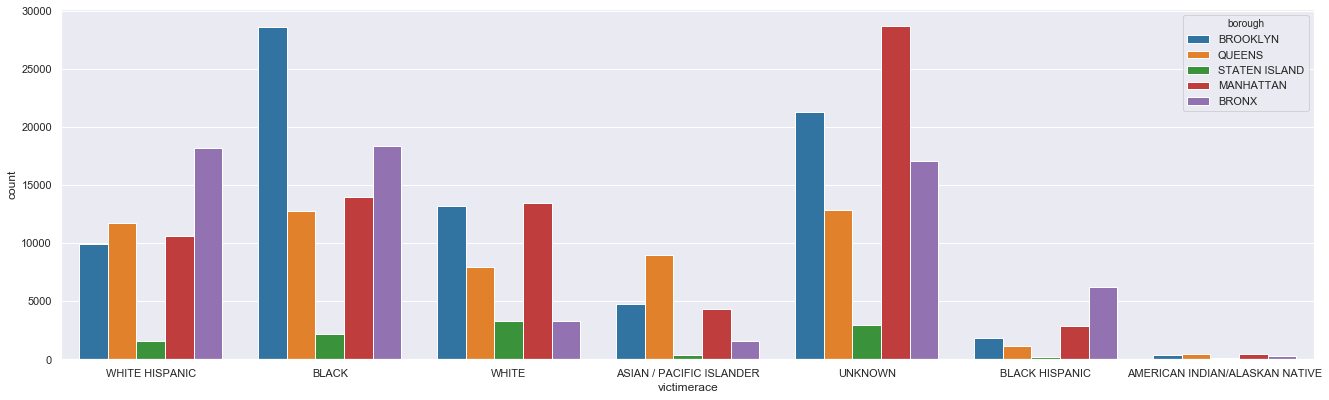

In [192]:
plt.figure(figsize=(20, 6))
sns.set(font_scale = 1)
fig=sns.countplot(data=crime,x='victimerace',hue="borough",palette="tab10")
plt.show()

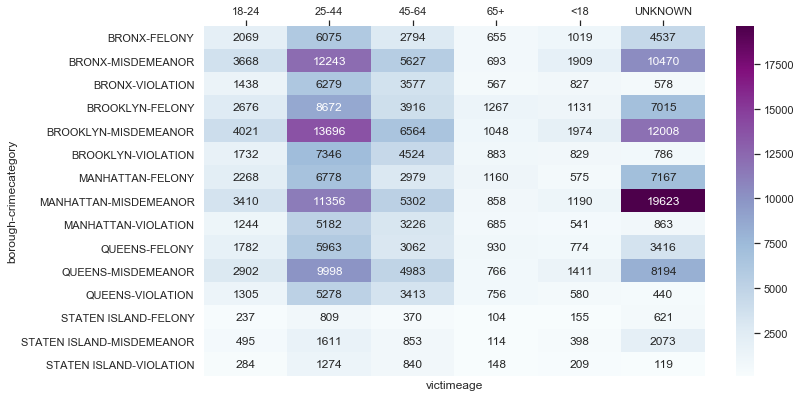

In [193]:
table = pd.pivot_table(crime, values='victimerace', index=['borough','crimecategory'],
                    columns=['victimeage'], aggfunc='count')
plt.figure(figsize=(10, 6))
ax = sns.heatmap(table, annot=True, fmt="d",cmap="BuPu")
ax.xaxis.set_ticks_position('top')

In [194]:
table = pd.pivot_table(crime, values='victimerace', index=['borough','crimecategory'],
                    columns=['victimeage'], aggfunc='count')

<Figure size 432x288 with 0 Axes>

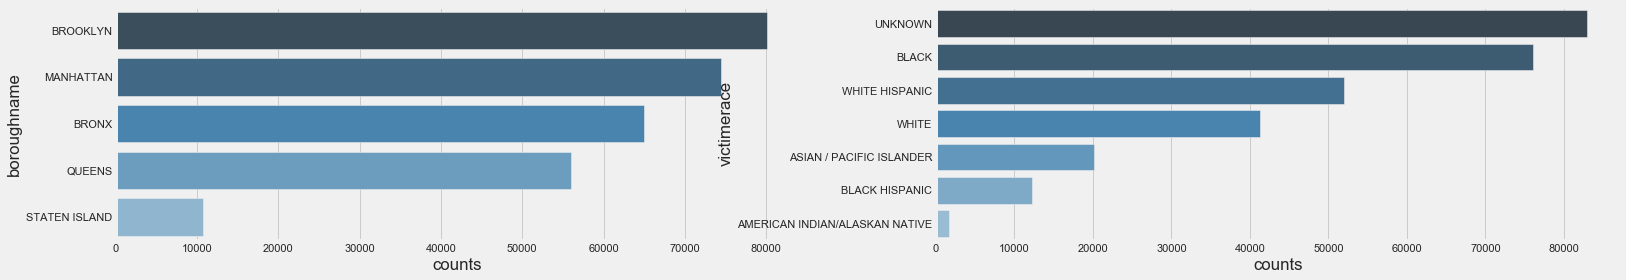

In [195]:
sns.despine(left=True)
plt.style.use('fivethirtyeight')
fig, ax =plt.subplots(1,2,figsize=(24,4))
boroughcount = pd.DataFrame(crime['borough'].value_counts(dropna=True, sort=True)).reset_index()
boroughcount.columns = ['boroughname', 'counts']
sns.barplot(y="boroughname", x="counts", data=boroughcount,palette="Blues_d", ax=ax[0])
victimeracecount = pd.DataFrame(crime['victimerace'].value_counts(dropna=True, sort=True)).reset_index()
victimeracecount.columns = ['victimerace', 'counts']
sns.barplot(y="victimerace", x="counts", data=victimeracecount,palette="Blues_d",ax=ax[1])


In [196]:
crime['reporteddate'] =  pd.to_datetime(crime['reporteddate'])
crimebyborough=crime.groupby([crime.reporteddate.dt.to_period("W"), 'borough']).borough.agg('count').to_frame('count').reset_index()
crimebyborough['reporteddate'] = crimebyborough['reporteddate'].dt.strftime('%Y-%m')

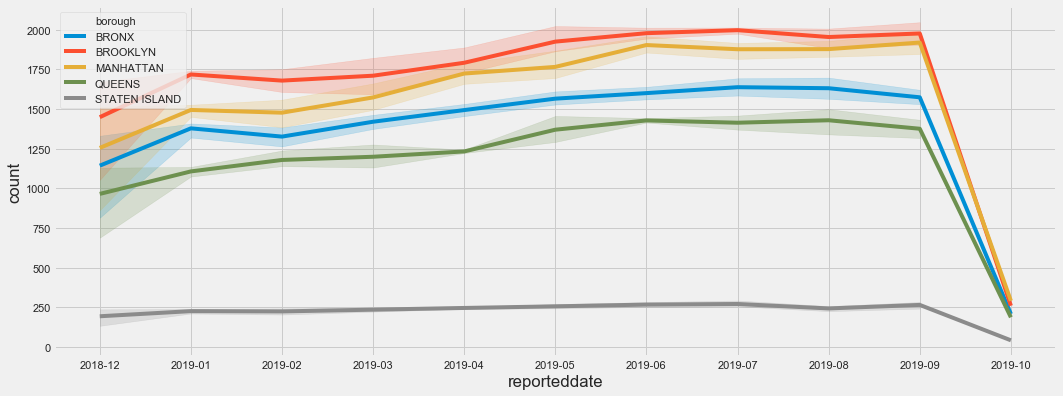

In [197]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x="reporteddate", y="count",
                  hue="borough", data=crimebyborough)
plt.show()

In [198]:
print(crime['borough'].value_counts())
print(crime['status'].value_counts())
print(crime['crimecategory'].value_counts())

BROOKLYN         80088
MANHATTAN        74407
BRONX            65025
QUEENS           55953
STATEN ISLAND    10714
Name: borough, dtype: int64
COMPLETED    281449
ATTEMPTED      4900
Name: status, dtype: int64
MISDEMEANOR    149459
FELONY          81137
VIOLATION       55753
Name: crimecategory, dtype: int64


#### Only Felonies
In the states, felonies are more serious offences and at times can even imprison an individual for life, while misdemeanors and violations are considered lower in comparison to a felony.Diving deeper into only crimes that are categoried as felonies gives us the following insights

In [199]:
felonies=crime[crime['crimecategory']=='FELONY']

In [200]:
crime['crimecategory'].value_counts()


MISDEMEANOR    149459
FELONY          81137
VIOLATION       55753
Name: crimecategory, dtype: int64

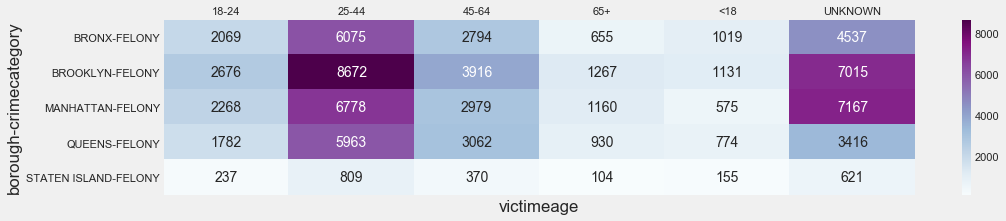

In [201]:
table = pd.pivot_table(felonies, values='victimerace', index=['borough','crimecategory'],
                    columns=['victimeage'], aggfunc='count')
plt.figure(figsize=(15, 3))
ax = sns.heatmap(table, annot=True, fmt="d",cmap="BuPu")
ax.xaxis.set_ticks_position('top')

*Taking a look at only felonies*

<Figure size 432x288 with 0 Axes>

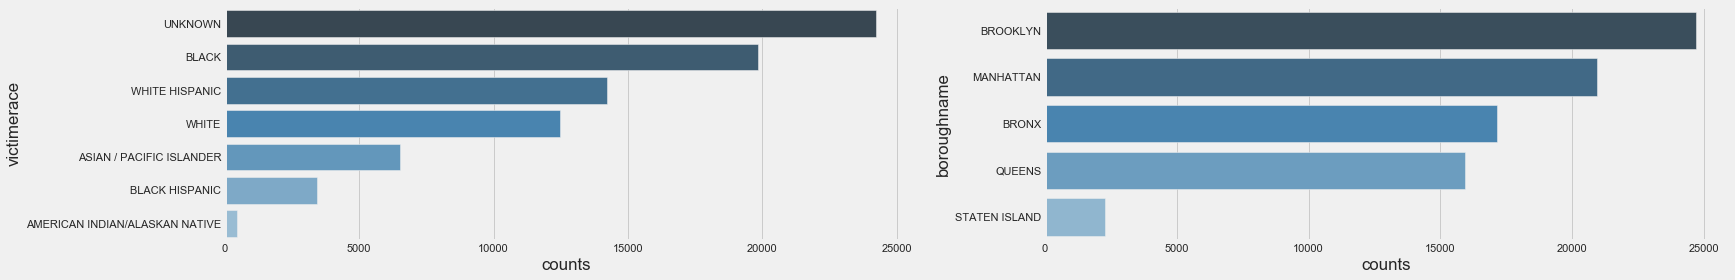

In [202]:
display(Markdown( "*Taking a look at only felonies*"))

sns.despine(left=True)
fig, ax =plt.subplots(1,2,figsize=(24,4))
victimeracecount = pd.DataFrame(felonies['victimerace'].value_counts(dropna=True, sort=True)).reset_index()
victimeracecount.columns = ['victimerace', 'counts']
sns.barplot(y="victimerace", x="counts", data=victimeracecount,palette="Blues_d",ax=ax[0])
boroughcount = pd.DataFrame(felonies['borough'].value_counts(dropna=True, sort=True)).reset_index()
boroughcount.columns = ['boroughname', 'counts']
sns.barplot(y="boroughname", x="counts", data=boroughcount,palette="Blues_d",ax=ax[1])


<a id='NYC'></a>
##  Sales Newyork Housing

Here we have a dataset taken from kaggle that gives us property sales from the years 2016 and 2017, we will utulize this to determine the neighbourhoods that support moderate housing costs,   and help us identify neightbourhoods that is skyhigh when it comes to rentals and property values.

#### Data Cleaning


In [122]:
sales=pd.read_csv("data/nyc-rolling-sales.csv",low_memory=False)
sales.columns = map(str.title, sales.columns)

bmap = {1: "Manhattan", 2: "Bronx", 3: "Brooklyn", 4: "Queens", 5: "Staten Island"}
sales['Borough']=sales['Borough'].map(bmap)
sales=sales.drop(columns=['Unnamed: 0','Ease-Ment'])
sales.head()

,Borough,Neighborhood,Building Class Category,Tax Class At Present,Block,Lot,Building Class At Present,Address,Apartment Number,Zip Code,Residential Units,Commercial Units,Total Units,Land Square Feet,Gross Square Feet,Year Built,Tax Class At Time Of Sale,Building Class At Time Of Sale,Sale Price,Sale Date
0,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [123]:
tonum=['Zip Code','Residential Units', 'Commercial Units', 'Total Units',
       'Land Square Feet', 'Gross Square Feet', 'Year Built',
       'Tax Class At Time Of Sale','Sale Price']
sales[tonum]=sales[tonum].apply(pd.to_numeric, errors='coerce')
sales.isnull().sum(axis = 0)
sales = sales[sales['Sale Price'].between(10000,1000000)]
sales = sales[sales['Land Square Feet'].between(100,10000)]
sales.shape

(22605, 20)

<Figure size 432x288 with 0 Axes>

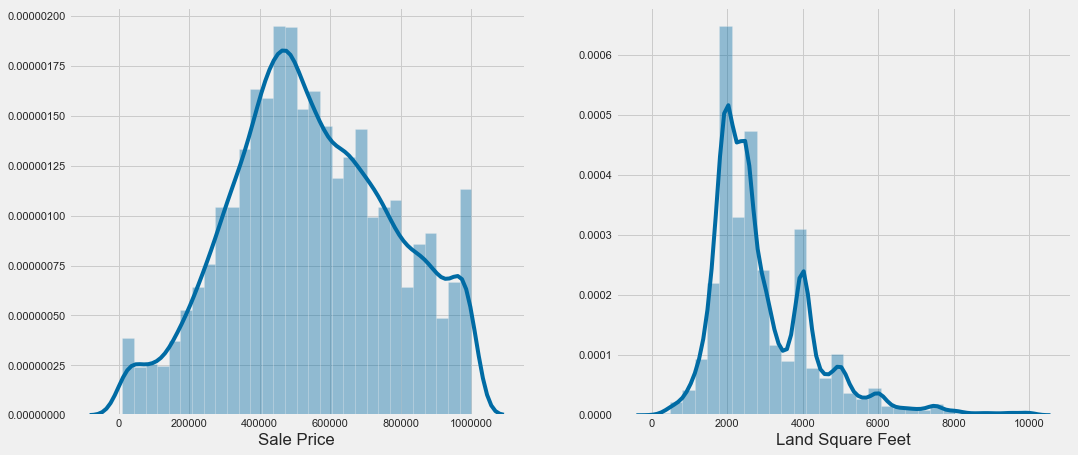

In [124]:
sns.despine(left=True)
plt.style.use('tableau-colorblind10')
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(16,7), sharey=False)

sns.distplot(sales['Sale Price'], bins =30,norm_hist=True,ax=ax1)

sns.distplot(sales['Land Square Feet'], bins =30,norm_hist=True, ax=ax2)

Text(0.5, 0, 'Distribution of Housing Cost')

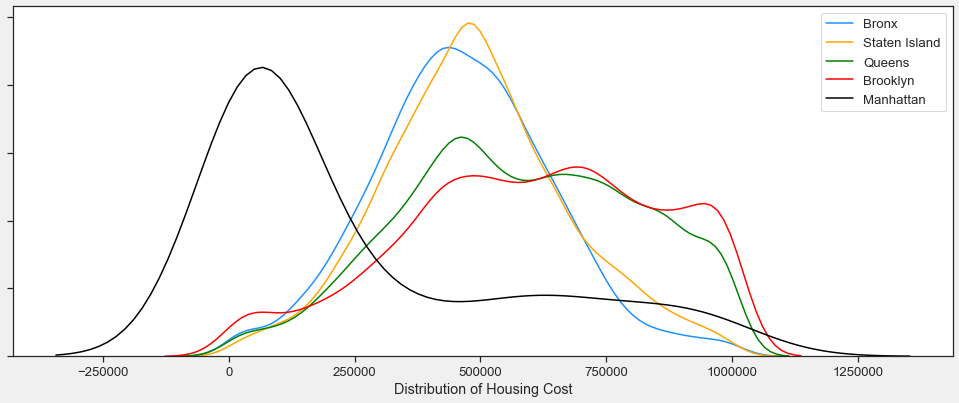

In [125]:
plt.figure(figsize=(15,6))
sns.set_style("ticks", {"xtick.major.size":2, "ytick.major.size": 8})
x1=sales.query('Borough == "Bronx"')
x2=sales.query('Borough == "Staten Island"')
x3=sales.query('Borough == "Queens"')
x4=sales.query('Borough == "Brooklyn"')
x5=sales.query('Borough == "Manhattan"')
sns.set_context("notebook", font_scale=1.2)
v=sns.distplot(x1["Sale Price"], color="dodgerblue" ,label="Bronx",hist=False)
v=sns.distplot(x2["Sale Price"], color="orange" ,label="Staten Island",  hist=False)
v=sns.distplot(x3["Sale Price"], color="green" ,label="Queens", hist=False)
v=sns.distplot(x4["Sale Price"], color="red" ,label="Brooklyn",  hist=False)
v=sns.distplot(x5["Sale Price"], color="black" ,label="Manhattan", hist=False)
v.set(yticklabels=[])
v.set_xlabel('Distribution of Housing Cost')

In [126]:
sales.Borough.value_counts()
plt.style.use('bmh')


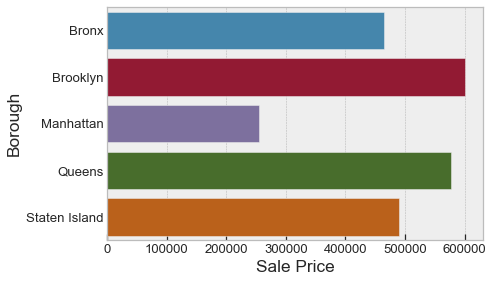

In [127]:
pivot=sales.pivot_table(index='Borough', values='Sale Price', aggfunc=np.mean)
ax = sns.barplot(y=pivot.index, x="Sale Price", data=pivot)

From the distribution plot we can immediately see that cost of housing in manhattan is the lowest followed by bronx and staten island being close with each other and brookly and queens being close to each other, how ever when we take the number of listings in the dataset it is found that manhattan has very few sales data and hence its hard to draw a conclusion on the distributions of the cost of housing from this particular method.

In [128]:
sum(sales.duplicated(sales.columns))
sales = sales.drop_duplicates(sales.columns, keep='last')

In [129]:
sales= sales.dropna()
sales = sales[sales['Total Units'].between(1, 25)]
sales.shape

(21822, 20)

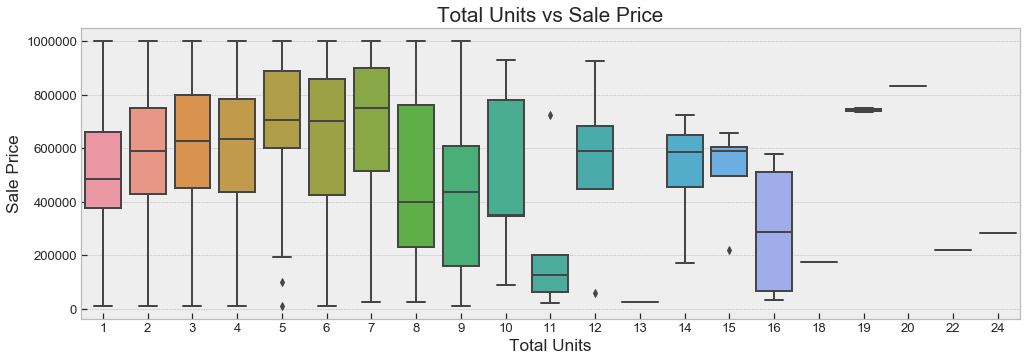

In [130]:
plt.figure(figsize=(15,5))
plt.style.use('tableau-colorblind10')
sns.boxplot(x='Total Units', y='Sale Price', data=sales)
plt.title('Total Units vs Sale Price')
plt.show()

In [131]:
del sales['Address']
del sales['Apartment Number']
sales['Sale Date']= pd.to_datetime(sales['Sale Date'])


Here we will get the average sales prices and squarefeet for the all respective neighborhood and boroughs

In [222]:
display(Markdown( "*This shows the list of neighbourhoods that have the lowest average cost ranked in ascending*"))
sales['Neighborhood'].value_counts()
sales['Neighborhood']=sales['Neighborhood'].str.title()
sales['location']=sales['Neighborhood']+ ', ' +sales['Borough']
sales['location'].value_counts()
table = pd.pivot_table(sales, values=['Sale Price', 'Land Square Feet'], index=['Borough', 'Neighborhood','Zip Code'],
                    aggfunc={'Sale Price': np.mean,'Land Square Feet': np.mean})
table=table.astype(int)
table=table.round()
table.sort_values(by='Sale Price', ascending=True).head(10)

*This shows the list of neighbourhoods that have the lowest average cost ranked in ascending*

Land Square Feet  Sale Price
Borough   Neighborhood            Zip Code                              
Brooklyn  East New York           0                     2000       25000
Manhattan Upper East Side (59-79) 10075                 1443       52500
          Midtown West            10019                 7532       68261
Brooklyn  Coney Island            0                     3502      100000
Queens    Jamaica Bay             11692                 4247      110000
                                  11422                 2500      135000
Brooklyn  Downtown-Fulton Mall    11201                 2174      149000
          Boerum Hill             11201                 1871      150000
          Clinton Hill            11238                 3045      167000
Manhattan Harlem-Central          10026                 1682      180000

Since the cost of a house is wide and diverse across the neighbourhoods and its hard to dermine the cheapest borough with the dataset at hand, and not only that the peliminary EDA shows that the boroughts have neighbourhoods that are both in high and low cost, if we compare this with our crimes analysis of newyork it favours Staten island over the other boroughs, but this is also due to the fact that staten island is actually quite far away and most people prefer to live in the other boroughts. For this project we need to find the middle ground between the safety of a borough and the cost of housing in its neightbourhood and hence we narrow it down to a mix of boroughs that are relatively cheap, for getting good locations from the foursquare api we will be looking at venues that are relavant to a person who wishing to have all essentail ammenities that are easily accessable and not at a very far distance from the location of the neighborhood.

Brooklyn and manhattan show a lot of crimes, especially a lot of felonies hence we will be removing all neighbourhoods belonging to these two boroughs

In [133]:
table=table.query("Borough == ['Bronx','Queens','Staten Island']").sort_values(by='Sale Price', ascending=True)
print(f'Total number of neighbourhoods with lost cost excluding Brooklyn and Manhattan are {len(table)}')
table=table.head(45)
table=pd.DataFrame(table.to_records())


Total number of neighbourhoods with lost cost excluding Brooklyn and Manhattan are 322


Here we will take only 20 percent of the cheapest which gives up 30 neighbourhoods to choose from and identify the clusters of venues with the foursquare api

In [134]:

table=table.rename(columns={"Neighborhood": "Neighbourhood"})


In [135]:
df=geolocation(table)

In [136]:
cols_to_use = table.columns.difference(df.columns)
cols_to_use


Index(['Land Square Feet', 'Sale Price', 'Zip Code'], dtype='object')

In [137]:
four2=pd.merge(df, table[cols_to_use], left_index=True, right_index=True, how='outer')

In [138]:
four2=four2.dropna()

In [139]:

four2.drop_duplicates(subset ="search_name",keep = False, inplace = True)
four2.reset_index(inplace = True, drop = True)
four2

,search_name,lat,lon,importance,type,Neighbourhood,Borough,boundingbox,class,Land Square Feet,Sale Price,Zip Code
0,Astoria Queens,40.7720145,-73.9302673,0.667136,neighbourhood,Astoria,Queens,"[40.7719645, 40.7720645, -73.9303173, -73.9302...",place,4061,180000,11370
1,Co-Op City Bronx,40.8738889,-73.8294444,0.725617,neighbourhood,Co-Op City,Bronx,"[40.8738389, 40.8739389, -73.8294944, -73.8293...",place,5625,193333,10475
2,Fresh Kills Staten Island,40.5642715,-74.186255,0.722075,neighbourhood,Fresh Kills,Staten Island,"[40.5642215, 40.5643215, -74.186305, -74.186205]",place,5097,199501,10312
3,Maspeth Queens,40.723158,-73.912637,0.588337,neighbourhood,Maspeth,Queens,"[40.723108, 40.723208, -73.912687, -73.912587]",place,2000,205000,11385
4,Belmont Bronx,40.8552778,-73.8863889,0.515440,neighbourhood,Belmont,Bronx,"[40.8552278, 40.8553278, -73.8864389, -73.8863...",place,2154,270375,10460
5,Port Ivory Staten Island,40.6409366,-74.1801442,0.725303,neighbourhood,Port Ivory,Staten Island,"[40.6408866, 40.6409866, -74.1801942, -74.1800...",place,2952,277227,10303
6,Arverne Queens,40.5934173,-73.7895462,0.563190,suburb,Arverne,Queens,"[40.5734173, 40.6134173, -73.8095462, -73.7695...",place,2808,292283,11691
7,Broad Channel Queens,40.6064008,-73.81901879728136,0.660330,neighbourhood,Broad Channel,Queens,"[40.5970594, 40.6153344, -73.8248592, -73.8148...",place,3251,309400,11693
8,Fordham Bronx,40.8614754,-73.8905439,0.545961,station,Fordham,Bronx,"[40.8564754, 40.8664754, -73.8955439, -73.8855...",railway,2533,321333,10458
9,Concord-Fox Hills Staten Island,40.6151042,-74.0845859,0.617338,neighbourhood,Concord-Fox Hills,Staten Island,"[40.6150542, 40.6151542, -74.0846359, -74.0845...",place,1456,326905,10304


We now have 31 neighbourhoods across all the boroughs in the city to proceed with the foursquare API analysis.

We create a focal point on the map to view the selected neighbourhoods with folium.

In [140]:
nylatlong=geolocator.geocode('Red Hook Brooklyn, NY')
nylat=nylatlong.latitude
nylong=nylatlong.longitude
nylatlong

Location(Red Hook, New York, Brooklyn, Kings County, New York, 11231, United States of America, (40.6751032, -74.0095841, 0.0))

The map shows us the selected neighbourhoods which we will later group into clusters with the help of k-means clustering.\
Select the marker to view the name of the neighbourhood, Borough.

In [275]:

map_lon = folium.Map(location=[nylat, nylong], zoom_start=10)
# add markers to map
map_lon
for lat, lng, borough, neighborhood in zip(four2['lat'], four2['lon'], four2['Borough'], four2['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lon)  
    
map_lon

Now that we have the data that we need, we can now load the data and get the venues from the Foursquare API

<a id='FS'></a>
## Foursquare

The Access tokens and credentials are specified to access the application created.

In [142]:
CLIENT_ID='ISJTNZY0ZDS2ECWKEYMZV01MAVLKR52QIGX10OQFXTXOHT5A'
CLIENT_SECRET='2LT0DL2XFZIIYLX1KC0HTZ3PIYW20C2BD2R04UIOA3KPUJYE'
LIMIT = 150
radius = 5000

#### Getting the category indexes from froursquare

This step is necessart to determine which venue categories are essential, for example venues like Restaurants,supermarkets and metro stations are more essential than theaters, aquariums and golfcourses.

In [143]:
# get categories
url=f"https://api.foursquare.com/v2/venues/categories?client_secret={CLIENT_SECRET}&client_id={CLIENT_ID}&radius=5000&v=20161101&limit={LIMIT}"
cat=requests.get(url).json()

This gives us all the categories and subcategories that exist in the Foursquare database

In [226]:
total=0
output = pd.DataFrame()
da=cat['response']['categories']
for f in da:
    temp=f['categories']
    name=f['name']
    #print(i['shortName'])
    #print(len(i))
    row=len(temp)
    total=total+row
    for i in temp:
        #print(i['name'])
        i['group']=name
        temp1=i['categories']
        if i ==[]:
            
            output = output.append(i, ignore_index=True)
        else:
            
            for x in i['categories']:
                output = output.append(x, ignore_index=True)
            i['categories']=[]
            output = output.append(i, ignore_index=True)
print(output.group.value_counts())


Shop & Service                 145
Food                            92
Outdoors & Recreation           62
Professional & Other Places     43
Arts & Entertainment            36
Travel & Transport              34
College & University            23
Event                           12
Nightlife Spot                   7
Residence                        5
Name: group, dtype: int64


In [230]:
df_cat=output.drop(columns=['categories', 'icon','pluralName','shortName'])
df_cat=output[['id','group','name']]
print("The number of unique locations provided by foursquare are "+ str(df_cat.name.nunique()))


The number of unique locations provided by foursquare are 459


We now have the all the categories that we can querry in the foursquare places Api, we will be looking at essential catogories such as 
supermarkets, restaurants, hospitals and transportation, this is to be used when we want to isolate categroies that are deemed absolutly necessary for anyone,hence this is made available but not leveraged for the scope of this project as there are no specific requirements.

In [228]:
essential_venues=output[output['name'].str.match('Metro|Hospital|Market|restaurant|Indian|Italian',case=False)]


In [229]:
four2['lat'] = four2['lat'].astype('float64').round(2)
four2['lon'] = four2['lon'].astype('float64').round(2)


### Modelling 

Performing a K-means clustering on the data, this yeilds us a significant cluster groups based on the number of clusters chosen, we will also perform a peliminary analysis of our model using the Within-Cluster-Sum of Squared Errors to determine which K-value has the ideal cluster groups and similarities amoung cluster points in each cluster.

We define our function to parse our neighbourhood data to obtain venues from the Foursquare API's explore endpoints.Relavant post data is parsed into the API to get the desired venues and their corresponding details that we will be utilizing for making the clusters.


In [148]:
def getvenue(Neighborhood,lat,long,radius):
    explored=[]
    for nb, la, ln in zip(Neighborhood, lat, long):
        print(nb)

        api=f'https://api.foursquare.com/v2/venues/explore?client_secret={CLIENT_SECRET}&client_id={CLIENT_ID}&ll={la},{ln}&radius={radius}&v=20161101&limit={LIMIT}'
        res = s.get(api).json()
        time.sleep(1)
        
        res=res["response"]['groups'][0]['items']
        explored.append([(nb,la,ln,i['venue']['name'],i['venue']['location']['lat'],i['venue']['location']['lng'],i['venue']['categories'][0]['name']) for i in res])
    venues = pd.DataFrame([item for explored in explored for item in explored])
    venues.columns = ['Neighborhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
        
    return(venues)

We get the venue details for our neighbourhoods by calling the declared funtion and parsing the relavant data into it, the response is stored in a pandas Dataframe

In [231]:
df_venues=getvenue(four2['Neighbourhood'],four2['lat'],four2['lon'],5000)

Astoria
Co-Op City
Fresh Kills
Maspeth
Belmont
Port Ivory
Arverne
Broad Channel
Fordham
Concord-Fox Hills
Stapleton
West New Brighton
Springfield Gardens
Mariners Harbor
Rosebank
Laurelton
New Dorp-Beach
College Point
Port Richmond
Concord
Far Rockaway
Crotona Park
Bulls Head
Hollis
Fieldston
Cambria Heights
Queens Village
Midland Beach
New Brighton
Baychester
Wakefield


In [246]:
#four2.Neighbourhood
df_venues=df_venues.rename(columns={"Neighborhood": "Neighbourhood"})
df_venues.Neighbourhood.unique()

array(['Astoria', 'Co-Op City', 'Fresh Kills', 'Maspeth', 'Belmont',
       'Port Ivory', 'Arverne', 'Broad Channel', 'Fordham',
       'Concord-Fox Hills', 'Stapleton', 'West New Brighton',
       'Springfield Gardens', 'Mariners Harbor', 'Rosebank', 'Laurelton',
       'New Dorp-Beach', 'College Point', 'Port Richmond', 'Concord',
       'Far Rockaway', 'Crotona Park', 'Bulls Head', 'Hollis',
       'Fieldston', 'Cambria Heights', 'Queens Village', 'Midland Beach',
       'New Brighton', 'Baychester', 'Wakefield'], dtype=object)

In [247]:
df_venues.groupby('Neighbourhood').count()
print(f"The total number of unique venues from the API is {len(df_venues['Venue Category'].unique())}")
df_venues.head()

The total number of unique venues from the API is 255


,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.77,-73.93,Vesta Trattoria & Wine Bar,40.769809,-73.927796,Italian Restaurant
1,Astoria,40.77,-73.93,The Noguchi Museum,40.766735,-73.938445,Art Museum
2,Astoria,40.77,-73.93,King Souvlaki of Astoria,40.764304,-73.923671,Food Truck
3,Astoria,40.77,-73.93,Astoria Park,40.777315,-73.923792,Park
4,Astoria,40.77,-73.93,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop


The data is now transformed and one hot encoded making it numerical so that our linear clustering model k-means can be used on the data.\
The data is also removed of

In [248]:
df_encoded = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")
df_encoded['Neighbourhood'] = df_venues['Neighbourhood'] 

# add neighborhood column back to dataframe
col = df_encoded.pop("Neighbourhood")
df_encoded.insert(0, col.name, col)

df_encoded.columns.get_loc("Neighbourhood")
df_encoded = df_encoded.groupby('Neighbourhood').mean().reset_index()
df_encoded

,Neighbourhood,Accessories Store,Airport Food Court,Airport Lounge,Airport Service,American Restaurant,Arcade,Arepa Restaurant,Art Gallery,Art Museum,...,Vietnamese Restaurant,Vineyard,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Arverne,0.00,0.00,0.00,0.00,0.013514,0.00,0.013514,0.00,0.00,...,0.00,0.00,0.00,0.027027,0.00,0.00,0.00,0.00,0.00,0.00
1,Astoria,0.00,0.00,0.00,0.00,0.030000,0.00,0.000000,0.01,0.05,...,0.00,0.00,0.00,0.010000,0.00,0.00,0.00,0.02,0.00,0.00
2,Baychester,0.00,0.00,0.00,0.00,0.010000,0.00,0.010000,0.00,0.00,...,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.04,0.01
3,Belmont,0.00,0.00,0.00,0.00,0.000000,0.00,0.010000,0.00,0.00,...,0.00,0.00,0.00,0.010000,0.01,0.00,0.00,0.01,0.05,0.02
4,Broad Channel,0.01,0.00,0.06,0.01,0.000000,0.00,0.010000,0.00,0.00,...,0.00,0.00,0.00,0.020000,0.00,0.00,0.01,0.00,0.00,0.00
5,Bulls Head,0.00,0.00,0.00,0.00,0.010000,0.01,0.000000,0.00,0.01,...,0.00,0.00,0.01,0.000000,0.00,0.00,0.01,0.00,0.01,0.00
6,Cambria Heights,0.00,0.00,0.00,0.00,0.010000,0.00,0.000000,0.00,0.00,...,0.00,0.00,0.00,0.000000,0.00,0.01,0.00,0.00,0.00,0.00
7,Co-Op City,0.00,0.00,0.00,0.00,0.010000,0.00,0.010000,0.00,0.00,...,0.00,0.00,0.00,0.000000,0.01,0.00,0.00,0.00,0.00,0.00
8,College Point,0.00,0.00,0.01,0.00,0.010000,0.00,0.000000,0.00,0.00,...,0.03,0.00,0.01,0.010000,0.00,0.00,0.00,0.00,0.00,0.00
9,Concord,0.00,0.00,0.00,0.00,0.010000,0.00,0.000000,0.00,0.00,...,0.00,0.00,0.00,0.000000,0.00,0.01,0.00,0.00,0.01,0.00


In [249]:
df_rank=[]
columns=['Neighbourhood']
for i in range(1,11):
    string=f'Venue Rank {i}'
    columns.append(string)
for x in df_encoded['Neighbourhood']:
    print(f"Popular places in {x}")
    df_freq = df_encoded[df_encoded['Neighbourhood'] == x].T.reset_index()
    df_freq.columns = ['venue','Occurrence']
    df_freq = df_freq.iloc[1:]
    df_freq['Occurrence'] = df_freq['Occurrence'].astype(float)
    df_freq = df_freq.round({'Occurrence': 2})
    dx=df_freq.sort_values('Occurrence', ascending=False).reset_index(drop=True)
    temp1=dx.venue[:10].tolist() 
    temp1.insert(0, x) 
    df_rank.append(temp1)
    print(df_freq.sort_values('Occurrence', ascending=False).reset_index(drop=True).head(5),'\n')
rank=pd.DataFrame(df_rank,columns=columns)

Popular places in Arverne
         venue  Occurrence
0        Beach        0.45
1   Bagel Shop        0.05
2    Surf Spot        0.05
3  Pizza Place        0.03
4    Beach Bar        0.03 

Popular places in Astoria
               venue  Occurrence
0         Art Museum        0.05
1                Bar        0.04
2        Pizza Place        0.04
3             Bakery        0.04
4  Martial Arts Dojo        0.03 

Popular places in Baychester
                venue  Occurrence
0         Pizza Place        0.10
1  Italian Restaurant        0.07
2              Bakery        0.06
3                 Zoo        0.04
4       Deli / Bodega        0.04 

Popular places in Belmont
                venue  Occurrence
0         Pizza Place        0.08
1  Italian Restaurant        0.08
2                Park        0.07
3       Deli / Bodega        0.06
4                 Zoo        0.05 

Popular places in Broad Channel
            venue  Occurrence
0           Beach        0.25
1  Airport Lounge        

In [250]:
final_df=four2

## Modeling - sklearn kmeans
#### Clustering the neighbourhoods based on the Ranks

In [251]:
from sklearn.cluster import KMeans

In [266]:
rank=pd.DataFrame(df_rank,columns=columns)
final_df=four2
cluster = df_encoded.drop('Neighbourhood', 1)
X1 = cluster.iloc[: , :].values

algorithm = (KMeans(n_clusters = 5 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X1)
rank.insert(0, 'Cluster Labels', algorithm.labels_)
final_df = final_df.join(rank.set_index('Neighbourhood'), on='Neighbourhood')
final_df.columns

Index(['search_name', 'lat', 'lon', 'importance', 'type', 'Neighbourhood',
       'Borough', 'boundingbox', 'class', 'Land Square Feet', 'Sale Price',
       'Zip Code', 'Cluster Labels', 'Venue Rank 1', 'Venue Rank 2',
       'Venue Rank 3', 'Venue Rank 4', 'Venue Rank 5', 'Venue Rank 6',
       'Venue Rank 7', 'Venue Rank 8', 'Venue Rank 9', 'Venue Rank 10'],
      dtype='object')

In [267]:
final_df.isna().sum()
final_df['Cluster Labels'] = final_df['Cluster Labels'].astype(int)
final_df=final_df.drop(['search_name', 'type','boundingbox', 'class'], axis=1)
col = final_df.pop("Neighbourhood")
final_df.insert(0, col.name, col)

In [269]:
map_clusters = folium.Map(location=[nylat, nylong], zoom_start=10)

# set color scheme for the clusters
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(5)]
colors_array = cm.Set1(np.linspace(0, 1, len(ys)))
clr = [colors.rgb2hex(i) for i in colors_array]
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_df['lat'], final_df['lon'], final_df['Neighbourhood'], final_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=clr[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=.7).add_to(map_clusters)
       
map_clusters

### Analysis of Clusters  K=5

* There is a group that has only 1 neighbourhood and shows venues that exist along coastlines, with other minor subtle differences with groups four and two
* There is a group that is the largest cluster group of the lot and pizza and italian places frequent a lot on this group,since this is the largest cluster we can see than theres a wide array of venues in them
* There is a group that features a carribean restaurant, also features venues that are common across coastlines.
* There is a group that shows us that theres a similarity in terms of Italian Restaurants,Parks and Deli / Bodega places
* There is a group that is relatively small due to it being close to the sealine and this proximity gives us unique venues such as surf spots and coffe shops, that arent found in other cluster groups


In [255]:
'''Group 1'''
final_df[final_df['Cluster Labels']==0]

,Neighbourhood,lat,lon,importance,Borough,Land Square Feet,Sale Price,Zip Code,Cluster Labels,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
4,Belmont,40.86,-73.89,0.515440,Bronx,2154,270375,10460,0,Pizza Place,Italian Restaurant,Park,Deli / Bodega,Zoo,Garden,Mexican Restaurant,Bakery,Coffee Shop,Dessert Shop
8,Fordham,40.86,-73.89,0.545961,Bronx,2533,321333,10458,0,Pizza Place,Italian Restaurant,Park,Deli / Bodega,Zoo,Garden,Mexican Restaurant,Bakery,Coffee Shop,Dessert Shop
21,Crotona Park,40.84,-73.89,0.644356,Bronx,1978,366893,10457,0,Park,Deli / Bodega,Garden,Mexican Restaurant,Italian Restaurant,Pizza Place,Bakery,Latin American Restaurant,Café,Fast Food Restaurant
24,Fieldston,40.89,-73.90,0.497419,Bronx,2000,390000,10471,0,Park,Pizza Place,Trail,Deli / Bodega,Burger Joint,Mexican Restaurant,Bakery,Diner,Garden,Scenic Lookout
29,Baychester,40.86,-73.84,0.508559,Bronx,2522,397567,10469,0,Pizza Place,Italian Restaurant,Bakery,Zoo,Deli / Bodega,Mexican Restaurant,Garden,Caribbean Restaurant,Coffee Shop,Spanish Restaurant


In [256]:
'''Group 2'''
final_df[final_df['Cluster Labels']==1]

,Neighbourhood,lat,lon,importance,Borough,Land Square Feet,Sale Price,Zip Code,Cluster Labels,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
7,Broad Channel,40.61,-73.82,0.660330,Queens,3251,309400,11693,1,Beach,Airport Lounge,Coffee Shop,Surf Spot,Bagel Shop,Cosmetics Shop,Burger Joint,Bar,Ice Cream Shop,Donut Shop
20,Far Rockaway,40.61,-73.76,0.700554,Queens,3840,360000,0,1,Beach,Coffee Shop,Airport Lounge,Golf Course,Pizza Place,Surf Spot,Bagel Shop,Italian Restaurant,Chinese Restaurant,Supermarket


In [257]:
'''Group 3'''
final_df[final_df['Cluster Labels']==2]

,Neighbourhood,lat,lon,importance,Borough,Land Square Feet,Sale Price,Zip Code,Cluster Labels,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
0,Astoria,40.77,-73.93,0.667136,Queens,4061,180000,11370,2,Art Museum,Bar,Pizza Place,Bakery,Martial Arts Dojo,Ice Cream Shop,American Restaurant,Exhibit,Thai Restaurant,Brewery
1,Co-Op City,40.87,-73.83,0.725617,Bronx,5625,193333,10475,2,Pizza Place,Italian Restaurant,Bakery,Caribbean Restaurant,Pharmacy,Mexican Restaurant,Seafood Restaurant,Coffee Shop,Deli / Bodega,Diner
2,Fresh Kills,40.56,-74.19,0.722075,Staten Island,5097,199501,10312,2,Pizza Place,Italian Restaurant,Ice Cream Shop,Bakery,Restaurant,Coffee Shop,Park,Diner,Furniture / Home Store,Bagel Shop
3,Maspeth,40.72,-73.91,0.588337,Queens,2000,205000,11385,2,Bar,Pizza Place,Italian Restaurant,Bakery,Brewery,Cocktail Bar,Coffee Shop,Music Venue,Gourmet Shop,Café
5,Port Ivory,40.64,-74.18,0.725303,Staten Island,2952,277227,10303,2,Pizza Place,Ice Cream Shop,Fast Food Restaurant,Sandwich Place,Clothing Store,Department Store,Bar,Bank,Nightclub,Restaurant
9,Concord-Fox Hills,40.62,-74.08,0.617338,Staten Island,1456,326905,10304,2,Pizza Place,Italian Restaurant,Bakery,Park,Spa,Mexican Restaurant,Bar,Flower Shop,Chinese Restaurant,Coffee Shop
10,Stapleton,40.63,-74.08,0.633061,Staten Island,3300,336527,10304,2,Italian Restaurant,Pizza Place,Park,Bakery,Bar,Spa,Mexican Restaurant,Coffee Shop,Deli / Bodega,Ice Cream Shop
11,West New Brighton,40.63,-74.11,0.805440,Staten Island,2495,338348,10302,2,Italian Restaurant,Pizza Place,Bar,Coffee Shop,Burger Joint,Café,Bakery,Ice Cream Shop,Dessert Shop,Golf Course
13,Mariners Harbor,40.64,-74.16,0.705004,Staten Island,3426,339108,10303,2,Pizza Place,Ice Cream Shop,Italian Restaurant,Coffee Shop,Café,Clothing Store,American Restaurant,Bar,Bagel Shop,Diner
14,Rosebank,40.61,-74.07,0.614565,Staten Island,3690,350000,10304,2,Pizza Place,Italian Restaurant,Park,Bakery,Coffee Shop,Spa,Japanese Restaurant,Beach,Garden,Breakfast Spot


In [258]:
'''Group 4'''
final_df[final_df['Cluster Labels']==3]

,Neighbourhood,lat,lon,importance,Borough,Land Square Feet,Sale Price,Zip Code,Cluster Labels,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
12,Springfield Gardens,40.68,-73.75,0.661947,Queens,2079,339000,11411,3,Caribbean Restaurant,Pizza Place,Park,Pharmacy,Deli / Bodega,Southern / Soul Food Restaurant,Sandwich Place,Furniture / Home Store,Gym,Bakery
15,Laurelton,40.67,-73.75,0.566399,Queens,4950,352750,11411,3,Caribbean Restaurant,Pizza Place,Park,Airport Lounge,Deli / Bodega,Furniture / Home Store,Burger Joint,Coffee Shop,Gym,Cosmetics Shop
23,Hollis,40.71,-73.77,0.581214,Queens,3611,370074,11429,3,Pizza Place,Caribbean Restaurant,Park,Deli / Bodega,Coffee Shop,Sandwich Place,Vegetarian / Vegan Restaurant,Gym,Bakery,Sushi Restaurant
25,Cambria Heights,40.69,-73.74,0.657505,Queens,3455,390677,11411,3,Caribbean Restaurant,Pizza Place,Park,Italian Restaurant,Pharmacy,Bakery,Deli / Bodega,Fast Food Restaurant,Latin American Restaurant,Sandwich Place


In [259]:
'''Group 5'''
final_df[final_df['Cluster Labels']==4]

,Neighbourhood,lat,lon,importance,Borough,Land Square Feet,Sale Price,Zip Code,Cluster Labels,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
6,Arverne,40.59,-73.79,0.56319,Queens,2808,292283,11691,4,Beach,Bagel Shop,Surf Spot,Pizza Place,Beach Bar,Wine Bar,Bar,Board Shop,French Restaurant,Pharmacy


To run a few adidional analysis on our model we will use the elbow method to determine the ideal number of clusters for our data

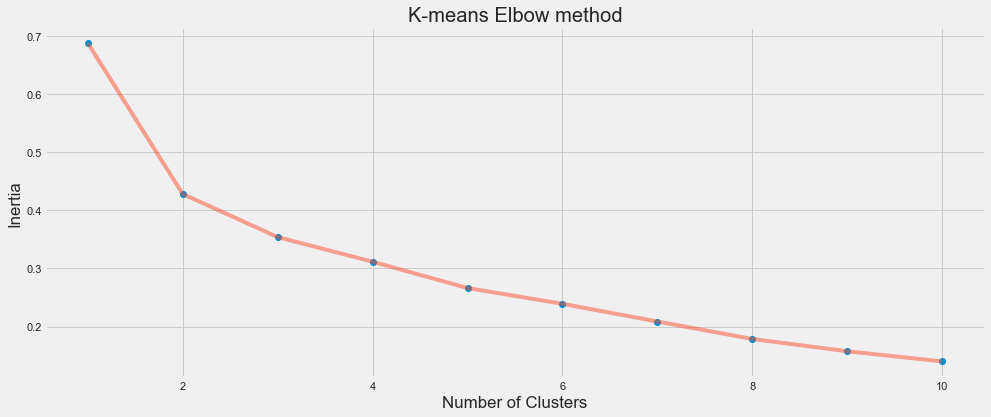

In [260]:
rank=pd.DataFrame(df_rank,columns=columns)
final_df=four2
cluster = df_encoded.drop('Neighbourhood', 1)
#cluster[cluster.columns.to_list()]=autoscaler.fit_transform(cluster[cluster.columns.to_list()])
X1 = cluster.iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)    
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.title('K-means Elbow method')
plt.show()

#### Setting k = 2 
Here we can note that despite having multiple columns that are used in the cluster there are significantly similar to each other and the ideal number of k should be 2,However we will be
using k value as 5 in the actual model as 2 cluster groups do not show much diffrenciation on the data at hand.


When we set k=2, Group 2 and 5 represent the first cluster, and the remaining points are the second cluster this is maily due to the change in venues as they are along the coastlines


In [271]:
rank=pd.DataFrame(df_rank,columns=columns)
final_df=four2
cluster = df_encoded.drop('Neighbourhood', 1)
X1 = cluster.iloc[: , :].values
algorithm = (KMeans(n_clusters = 2 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X1)
rank.insert(0, 'Cluster Labels', algorithm.labels_)
final_df = final_df.join(rank.set_index('Neighbourhood'), on='Neighbourhood')
final_df['Cluster Labels'] = final_df['Cluster Labels'].astype(int)
final_df=final_df.drop(['search_name', 'type','boundingbox', 'class'], axis=1)
col = final_df.pop("Neighbourhood")
final_df.insert(0, col.name, col)

In [272]:
map_clusters = folium.Map(location=[nylat, nylong], zoom_start=10)
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(5)]
colors_array = cm.Set1(np.linspace(0, 1, len(ys)))
clr = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(final_df['lat'], final_df['lon'], final_df['Neighbourhood'], final_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=clr[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=.7).add_to(map_clusters)
       
map_clusters

In [273]:
'''Group 1'''
final_df[final_df['Cluster Labels']==0]

,Neighbourhood,lat,lon,importance,Borough,Land Square Feet,Sale Price,Zip Code,Cluster Labels,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
6,Arverne,40.59,-73.79,0.563190,Queens,2808,292283,11691,0,Beach,Bagel Shop,Surf Spot,Pizza Place,Beach Bar,Wine Bar,Bar,Board Shop,French Restaurant,Pharmacy
7,Broad Channel,40.61,-73.82,0.660330,Queens,3251,309400,11693,0,Beach,Airport Lounge,Coffee Shop,Surf Spot,Bagel Shop,Cosmetics Shop,Burger Joint,Bar,Ice Cream Shop,Donut Shop
20,Far Rockaway,40.61,-73.76,0.700554,Queens,3840,360000,0,0,Beach,Coffee Shop,Airport Lounge,Golf Course,Pizza Place,Surf Spot,Bagel Shop,Italian Restaurant,Chinese Restaurant,Supermarket


In [274]:
'''Group 2'''
final_df[final_df['Cluster Labels']==1]

,Neighbourhood,lat,lon,importance,Borough,Land Square Feet,Sale Price,Zip Code,Cluster Labels,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
0,Astoria,40.77,-73.93,0.667136,Queens,4061,180000,11370,1,Art Museum,Bar,Pizza Place,Bakery,Martial Arts Dojo,Ice Cream Shop,American Restaurant,Exhibit,Thai Restaurant,Brewery
1,Co-Op City,40.87,-73.83,0.725617,Bronx,5625,193333,10475,1,Pizza Place,Italian Restaurant,Bakery,Caribbean Restaurant,Pharmacy,Mexican Restaurant,Seafood Restaurant,Coffee Shop,Deli / Bodega,Diner
2,Fresh Kills,40.56,-74.19,0.722075,Staten Island,5097,199501,10312,1,Pizza Place,Italian Restaurant,Ice Cream Shop,Bakery,Restaurant,Coffee Shop,Park,Diner,Furniture / Home Store,Bagel Shop
3,Maspeth,40.72,-73.91,0.588337,Queens,2000,205000,11385,1,Bar,Pizza Place,Italian Restaurant,Bakery,Brewery,Cocktail Bar,Coffee Shop,Music Venue,Gourmet Shop,Café
4,Belmont,40.86,-73.89,0.515440,Bronx,2154,270375,10460,1,Pizza Place,Italian Restaurant,Park,Deli / Bodega,Zoo,Garden,Mexican Restaurant,Bakery,Coffee Shop,Dessert Shop
5,Port Ivory,40.64,-74.18,0.725303,Staten Island,2952,277227,10303,1,Pizza Place,Ice Cream Shop,Fast Food Restaurant,Sandwich Place,Clothing Store,Department Store,Bar,Bank,Nightclub,Restaurant
8,Fordham,40.86,-73.89,0.545961,Bronx,2533,321333,10458,1,Pizza Place,Italian Restaurant,Park,Deli / Bodega,Zoo,Garden,Mexican Restaurant,Bakery,Coffee Shop,Dessert Shop
9,Concord-Fox Hills,40.62,-74.08,0.617338,Staten Island,1456,326905,10304,1,Pizza Place,Italian Restaurant,Bakery,Park,Spa,Mexican Restaurant,Bar,Flower Shop,Chinese Restaurant,Coffee Shop
10,Stapleton,40.63,-74.08,0.633061,Staten Island,3300,336527,10304,1,Italian Restaurant,Pizza Place,Park,Bakery,Bar,Spa,Mexican Restaurant,Coffee Shop,Deli / Bodega,Ice Cream Shop
11,West New Brighton,40.63,-74.11,0.805440,Staten Island,2495,338348,10302,1,Italian Restaurant,Pizza Place,Bar,Coffee Shop,Burger Joint,Café,Bakery,Ice Cream Shop,Dessert Shop,Golf Course


When we set k as '2' we get one large cluster and one small cluster with only 3 datapoints,Ideally we need more data diffrenciation amoung clusters so we will look at 5 cluster groups for more differenciation amoung the neighbourhoods.

## Results and Conclusion
This project helps us to understand how to approach a process of selection and elimination based on a set of prequisites that are deemed essential to choosing a good neighbourhood. The main aspects of the selection are the following three paramenters.
* Housing Cost
* Neighbourhood Safety
* Proximity of Essential Venues

The most suitable neighbourhoods are selected across the varios boroughs,as all boroughs have certain neighbourhoods that vary to both extrem ends in the cost of housing as well as the safety of the neighbourhood.
The neighbourhoods are selected and with the Foursquare API the venues are collected and they are clustered together for essential venues that are of higher importance than the rest,they are grouped accrodingly with the help of k-means and are depicted on the map of the Boroughs in Newyork City


The data has been loaded from various sources and exploratory data analysis has been performed on all of the datasets,all necessary cleaning procedures and mining procedures have been followed to ensure the data is in the proper format.\
The findings and interpretations from the visualizations that are gained from the crime and housing datasets, enabled us to narrow it down to our select group of neighbourhoods that we are able to utilize with our foursquare Api to identify ideal locations that are suitable based on venues preferences.\
The Average cost of housing and square feet of each housing unit is also made available for making a calculated decision on purchase of a house.

**The findings are made to match with real world knowledge of the city on NewYork to make correct decision in the EDA process.**

### Key Findings
* Crimes in the city of New York are classified into three main categories- Felonies, misdemeanors and violations. The US federal system deems Felonies as a bigger crime in comparison to the other two.
* Staten Island is much further away from the city and it takes time for one to tavel to the other Boroughs in the city, hence is also can impact the decison making process for choosing a suitable home in the aforementioned borough.
* Crimes in Brooklyn and Manhattan show not only an average high on all categories but especially in the form of misdemeanors, our crime data only is Borough specific and doesnt contain neighbourhood data hence we remove these two boroughs, not only on the aspect of safety but also on the average cost of housing.
* Housing costs in Manhattan are found to be the lowest, this could also be due to the fact that after striping the data for ranges between housing costs and land square feet into realistic numbers and removing data points that have Null values we dont have much data points from Manhattan.
* We can presume that Bronx and Staten Island have decent housing in the states, as over the past few years crime rates have dropped drastically in the Bronx which was once a crime infested borough and Staten Island has seen a steady increase in its housing and development from the State of Newyork.
* Our final dataset contains boroughs from Bronx, Staten Island and Queens.It is hard to correlate a whole Borough to a particular parameter like cost or safety hence we look at individual boroughs for determining the cheapest locations.
* The main reason we mix and choose from 3 different boroughts is because, it is hard to choose one borough as the ideal as most boroughs have neighbourhoods that are at extreme ends in terms of safety and cost of housing.
* The venues are picked from the Foursquare API and they are clustered into groups with k-means, and each group tends to have certain similarities in them along the rankings of their venues and the frequency of a venues categorical importance and occurance in that area.

This project can be modified using the selections and even refined even further with more data specific to each neighbourhood to determine the best neighbourhood to live in based on personal preferences. This is also helpful to someone who needs to shortlist areas based on distances from their places of work, their choice of essential venues etc. The end results shown in the clusters only denote one point of view of extremely cheap neighbourhoods, They can be modified with a selective range on the cost and mitigation on the safety to narrow it down to a list of ideal neighbourhoods to live in the city of New York.